# ТЕЛЕКОМ

## Описание проекта

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

Целью работы является подбор модели и гиперпараметров к ней с метрикой ROC-AUC не менее 0.8

### Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `CustomerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

### Обозначение признаков

* `BeginDate` - дата начала пользования услугами,
* `EndDate` - дата окончания пользования услугами,
* `Type` - тип оплаты: ежемесячный, годовой и т.д.,
* `PaperlessBilling` - безналичный расчет,
* `PaymentMethod` - способ оплаты,
* `MonthlyCharges` - ежемесячные траты на услуги,
* `TotalCharges` - всего потрачено денег на услуги,
* `Dependents` - наличие иждивенцев,
* `SeniorCitizen` - наличие пенсионного сатуса по возрасту,
* `Partner` - наличие супруга(и),
* `MultipleLines` - наличие возможности ведения параллельных линий во вермя звонка.



## Изучение данных, построение графиков, преобразование типов данных

In [ ]:
pip install phik #устанавливаем новую библиотеку для расчета Phi корреляции

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.8 MB 1.4 MB/s 


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt

import phik
from phik import report
from phik.report import plot_correlation_matrix

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve 

from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from catboost import CatBoostClassifier

from sklearn.utils import shuffle

import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')

In [ ]:
SEED = 171022
date_format = "%Y-%m-%d"

In [ ]:
df_contract = pd.read_csv('/content/14_contract.csv')
df_personal = pd.read_csv('/content/14_personal.csv')
df_internet = pd.read_csv('/content/14_internet.csv')
df_phone = pd.read_csv('/content/14_phone.csv')

In [ ]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [ ]:
df_contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [ ]:
df_contract.describe()

,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


In [ ]:
df_contract[df_contract['TotalCharges']==' ']

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,


Тип данных в колонке TotalCharges поменяем на float, предварительно заменим пропущенные значения на нули. От таких клиентов платежи не поступали, т.к. контракты на обслуживание только заключили.

In [ ]:
df_contract['TotalCharges']=df_contract['TotalCharges'].replace(' ','0').astype(float)

In [ ]:
df_contract['BeginDate']=pd.to_datetime(df_contract['BeginDate'], format = date_format) #поменяем тип данных на datetime
df_contract['EndDate']=pd.to_datetime(df_contract[df_contract['EndDate']!='No']['EndDate'],format = date_format)
df_contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,1889.50
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65


Все колонки теперь имеют адекватные типы данных.

Посмотрим на распределение данных в `TotalCharges`

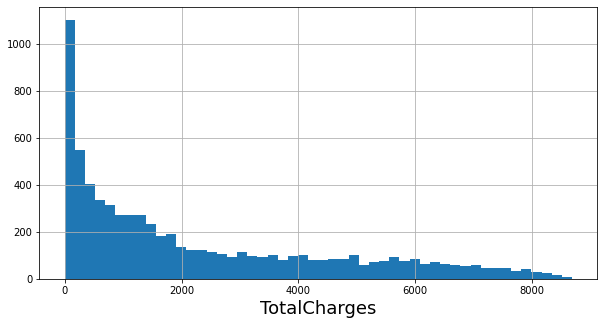

In [ ]:
plt.figure(figsize=(10,5)) #посмотрим на распределение TotalCharges на гистограмме
plt.grid()
plt.hist(df_contract['TotalCharges'], bins=50);
plt.xlabel('TotalCharges',fontsize=18)
plt.show()

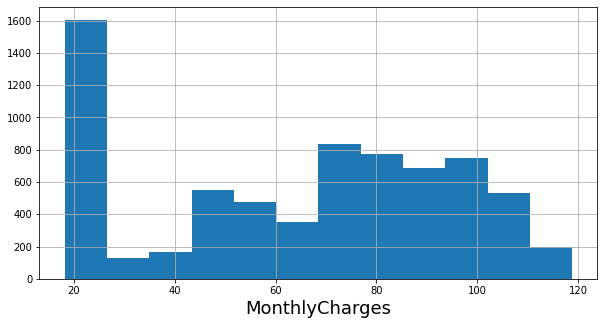

In [ ]:
plt.figure(figsize=(10,5)) #посмотрим на распределение MonthlylCharges на гистограмме
plt.grid()
plt.hist(df_contract['MonthlyCharges'], bins=12);
plt.xlabel('MonthlyCharges',fontsize=18)
plt.show()

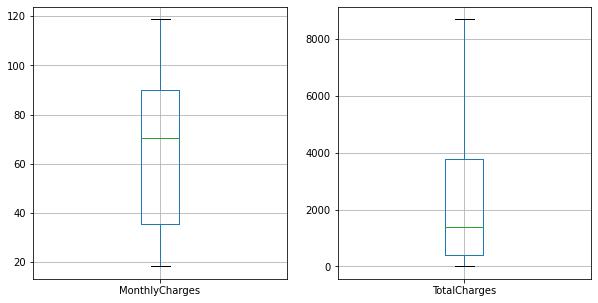

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
df_contract.boxplot('MonthlyCharges', ax=ax[0])
df_contract.boxplot('TotalCharges', ax=ax[1]);


В среднем клиенты пллатят 70`$` в месяц и 1500`$`  за всю историю пользования тарифом.

Посмотрим на зависимость `TotalCharges` и `EndDate`.

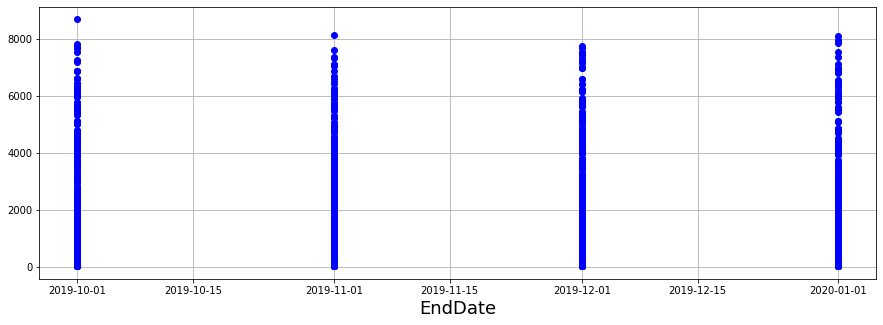

In [ ]:
plt.figure(figsize=(15,5))
plt.grid()
plt.plot(df_contract[df_contract['EndDate']!=0]['EndDate'],df_contract['TotalCharges'],'bo');
plt.xlabel('EndDate',fontsize=18)
plt.show()

Здесь можно отметить, что выплаты фиксируются на начало каждого месяца.

Рассмотрим зависимость `TotalCharges` и `BeginDate`.

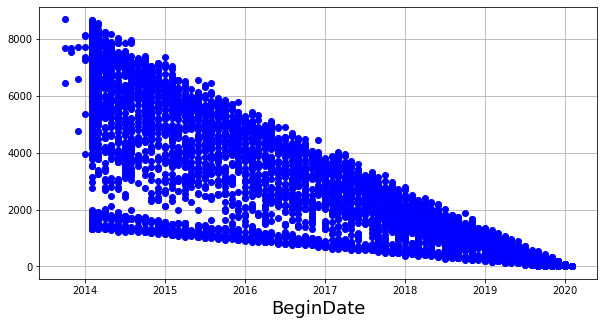

In [ ]:
plt.figure(figsize=(10,5))
plt.grid()
plt.plot(df_contract['BeginDate'],df_contract['TotalCharges'],'bo');
plt.xlabel('BeginDate',fontsize=18)
plt.show()

График ожидаемо показывает накопление общих платежей с течением времени: чем больше прошло времени, тем больше сумма общих платежей.

На следующем графике посмотрим, какой тип оплаты наиболее популярен.

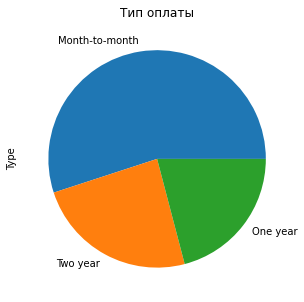

In [ ]:
df_contract['Type'].value_counts().plot(kind='pie',figsize=(10,5),title='Тип оплаты');

Ежемесячный тип оплаты в лидерах.

Посмотрим на распределение клиентов по методам оплаты.

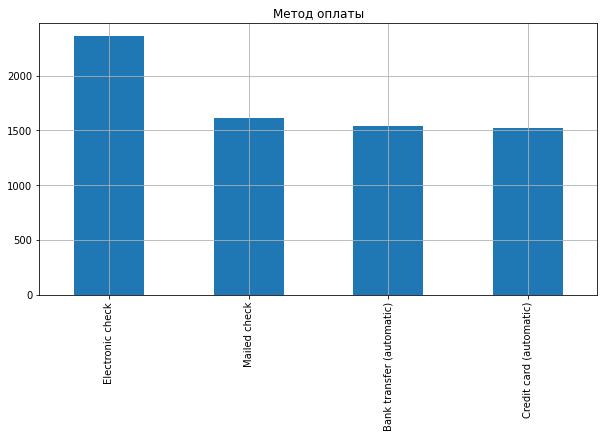

In [ ]:
df_contract['PaymentMethod'].value_counts().plot(kind='bar',figsize=(10,5),grid='Yes', title='Метод оплаты'); 

Наиболее популярен у клиентов электронный чек, остальные методы распределены между клиентами практически поровну.

In [ ]:
df_personal.info() #изучим датасет с персональными данными клиентов

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [ ]:
df_personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


Посмотрим на распределение клиентов по возрастам.

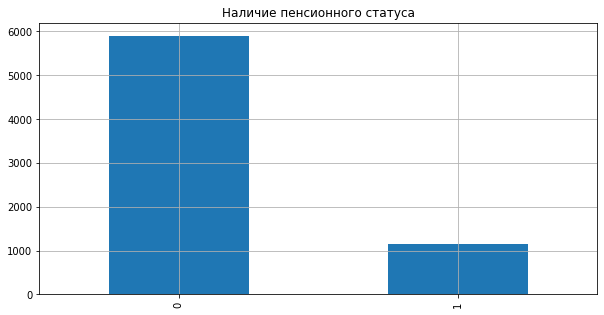

In [ ]:
df_personal['SeniorCitizen'].value_counts().plot(kind='bar',figsize=(10,5),grid='Yes', title='Наличие пенсионного статуса');

Подавляющее число клиентов еще не имеют пенсионного статуса.

In [ ]:
df_personal.describe() 

,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


Аномалий в данных датафрема с персональными данными нет.

In [ ]:
df_internet.info()#изучим датасет по пользованию интернет услугами

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [ ]:
df_internet.head() 

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


Все признаки в датасете категориальные, аномалии не отмечаются.

In [ ]:
df_phone.info( )#изучим датасет по пользованию телефонией

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [ ]:
df_phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


Здесь аналогично предыдущему датасету - все признаки в датасете категориальные, аномалии не отмечаются.

## Предобработка данных

### Объединение таблиц

Для дальнейшей работы объединим данные из четырех имеющихся датасетов в один.

In [ ]:
df=df_contract.merge(df_personal,on='customerID',how='left')
df=df.merge(df_internet,on='customerID',how='left')
df=df.merge(df_phone,on='customerID',how='left')
df.head(10)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,1889.50,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No
5,9305-CDSKC,2019-03-01,2019-11-01,Month-to-month,Yes,Electronic check,99.65,820.50,Female,0,No,No,Fiber optic,No,No,Yes,No,Yes,Yes,Yes
6,1452-KIOVK,2018-04-01,NaT,Month-to-month,Yes,Credit card (automatic),89.10,1949.40,Male,0,No,Yes,Fiber optic,No,Yes,No,No,Yes,No,Yes
7,6713-OKOMC,2019-04-01,NaT,Month-to-month,No,Mailed check,29.75,301.90,Female,0,No,No,DSL,Yes,No,No,No,No,No,NaN
8,7892-POOKP,2017-07-01,2019-11-01,Month-to-month,Yes,Electronic check,104.80,3046.05,Female,0,Yes,No,Fiber optic,No,No,Yes,Yes,Yes,Yes,Yes
9,6388-TABGU,2014-12-01,NaT,One year,No,Bank transfer (automatic),56.15,3487.95,Male,0,No,Yes,DSL,Yes,Yes,No,No,No,No,No


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           1869 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   int64         
 10  Partner           7043 non-null   object        
 11  Dependents        7043 non-null   object        
 12  InternetService   5517 non-null   object        
 13  OnlineSecurity    5517 non-null   object        
 14  OnlineBackup      5517 n

Получили датасет с 19 признаками, типы данных адекватные, но имеются пропуски.

### Добавление и удаление признаков, генерация целевого признака

В данном разделе создадим целевой признак для моделирования, добавим новый признак из имеющихся данных.
После преобразований уберем лишние признаки.

In [ ]:
df['EndDate']=df['EndDate'].fillna('2020-02-01') #заполним пропуски в столбце EndDate текущей датой
df['EndDate']=pd.to_datetime(df['EndDate'],format=date_format)
df.loc[df['EndDate']=='2020-02-01',
          'Churn']=0 #если окончание действия договора соответсвует текущей дате, значит договор еще не завершен
df.loc[df['EndDate']!='2020-02-01',
          'Churn']=1 #если дата окончания договора отличается от текущей даты, значит договор завершен
round(df['Churn'].value_counts('0')*100) #проверим распределение завршенных и незавершенных договоров


0.0    73.0
1.0    27.0
Name: Churn, dtype: float64

У 27% клиентов из имеющейся выборки договор уже завершен, остальные 73% продолжают пользоваться услугами телекома. Целевой признак несбалансирован, учтем это при подборе параметров для моделей.

In [ ]:
df['UsagePeriod']=df['EndDate']-df['BeginDate'] #создадим новый признак - количество дней пользования услугами 
df['UsagePeriod']=df['UsagePeriod'].dt.days
df=df.drop(columns=['BeginDate','EndDate','customerID']) #удалим лишние столбцы, не требующиеся для обучения
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7043 non-null   object 
 1   PaperlessBilling  7043 non-null   object 
 2   PaymentMethod     7043 non-null   object 
 3   MonthlyCharges    7043 non-null   float64
 4   TotalCharges      7043 non-null   float64
 5   gender            7043 non-null   object 
 6   SeniorCitizen     7043 non-null   int64  
 7   Partner           7043 non-null   object 
 8   Dependents        7043 non-null   object 
 9   InternetService   5517 non-null   object 
 10  OnlineSecurity    5517 non-null   object 
 11  OnlineBackup      5517 non-null   object 
 12  DeviceProtection  5517 non-null   object 
 13  TechSupport       5517 non-null   object 
 14  StreamingTV       5517 non-null   object 
 15  StreamingMovies   5517 non-null   object 
 16  MultipleLines     6361 non-null   object 


### Заполнение пропусков

Рассмотрим какие столбцы датафрейма содержат пропуски.

In [ ]:
pd.isna(df).sum()

Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
MultipleLines        682
Churn                  0
UsagePeriod            0
dtype: int64

Пропуски есть в признаках: `'OnlineSecurity','InternetService','OnlineBackup','DeviceProtection','TechSupport','StreamingTV',
'StreamingMovies','MultipleLines'` Все признаки относятся к категориальным, отсутствие данных в них может свидетельствовать о том, что такой услугой клиент не пользуется. Заполним пропущенные данные значением `No`

In [ ]:
columns=['OnlineSecurity','InternetService','OnlineBackup','DeviceProtection',
         'TechSupport','StreamingTV','StreamingMovies','MultipleLines']
for column in columns:
    df.loc[df[column].isna(),column]='No'
pd.isna(df).sum()

Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
MultipleLines       0
Churn               0
UsagePeriod         0
dtype: int64

Пропусков в данных нет после выполнения алгоритма.

Избавимся от явных дубликатов.

In [ ]:
df.duplicated().sum() #посчитаем количество явных дубликатов

18

In [ ]:
df = df.drop_duplicates().reset_index(drop=True) #удалим явные дубликаты из таблицы
df_numeric=df[['TotalCharges','MonthlyCharges', 
                'Churn', 
               'UsagePeriod']] #выделим числовые признаки в отдельный датасет, он потребуется нам для OHE кодирования признаков

In [ ]:
df.drop(['SeniorCitizen'],axis=1).corr() #проверим корреляцию числовых данных датасета

,MonthlyCharges,TotalCharges,Churn,UsagePeriod
MonthlyCharges,1.000000,0.650703,0.193688,0.245416
TotalCharges,0.650703,1.000000,-0.197925,0.825631
Churn,0.193688,-0.197925,1.000000,-0.352728
UsagePeriod,0.245416,0.825631,-0.352728,1.000000


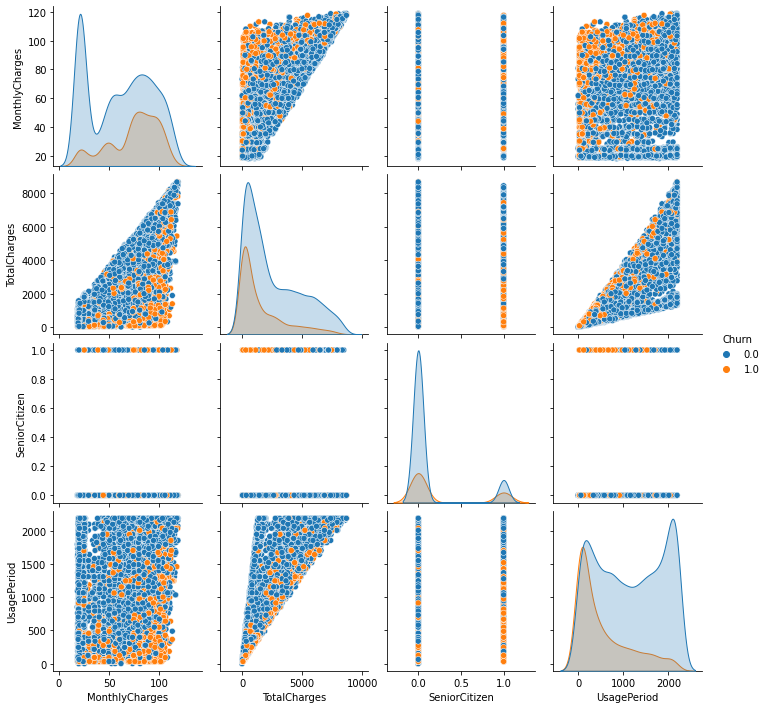

In [ ]:
sns.pairplot(df,hue='Churn');

Как видно из расчета и парных графиков, между признаками `Usage Period` и `TotalCharges` есть сильная корреляция (0.83). Учтем это при построении модели логистической регрессии и при необходимости избавимся от одного из признаков. 

Следует также отметить наличие обратной корреляции между длительностью пользования и фактом ухода клиентов - чем дольше клиент пользуется тарифом, тем меньше вероятность того, что он уйдет.

In [ ]:
df_corr=df.drop(columns= ['TotalCharges','MonthlyCharges', 
                          'SeniorCitizen', 'Churn', 'UsagePeriod']) #проверим корреляцию данных в категориальных признаках
phik_overview=df_corr.phik_matrix()
phik_overview.round(2)

,Type,PaperlessBilling,PaymentMethod,gender,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
Type,1.00,0.11,0.28,0.00,0.18,0.15,0.51,0.15,0.10,0.14,0.18,0.07,0.07,0.06
PaperlessBilling,0.11,1.00,0.37,0.00,0.02,0.17,0.23,0.00,0.20,0.16,0.06,0.34,0.33,0.25
PaymentMethod,0.28,0.37,1.00,0.00,0.24,0.23,0.32,0.26,0.28,0.30,0.27,0.38,0.38,0.34
gender,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.02,0.01,0.00,0.00,0.00,0.00,0.00
Partner,0.18,0.02,0.24,0.00,1.00,0.65,0.00,0.22,0.22,0.24,0.18,0.19,0.18,0.22
Dependents,0.15,0.17,0.23,0.00,0.65,1.00,0.11,0.12,0.03,0.01,0.10,0.02,0.06,0.04
InternetService,0.51,0.23,0.32,0.00,0.00,0.11,1.00,0.24,0.23,0.23,0.24,0.27,0.27,0.23
OnlineSecurity,0.15,0.00,0.26,0.02,0.22,0.12,0.24,1.00,0.43,0.42,0.53,0.27,0.29,0.15
OnlineBackup,0.10,0.20,0.28,0.01,0.22,0.03,0.23,0.43,1.00,0.46,0.44,0.43,0.42,0.31
DeviceProtection,0.14,0.16,0.30,0.00,0.24,0.01,0.23,0.42,0.46,1.00,0.50,0.57,0.59,0.31


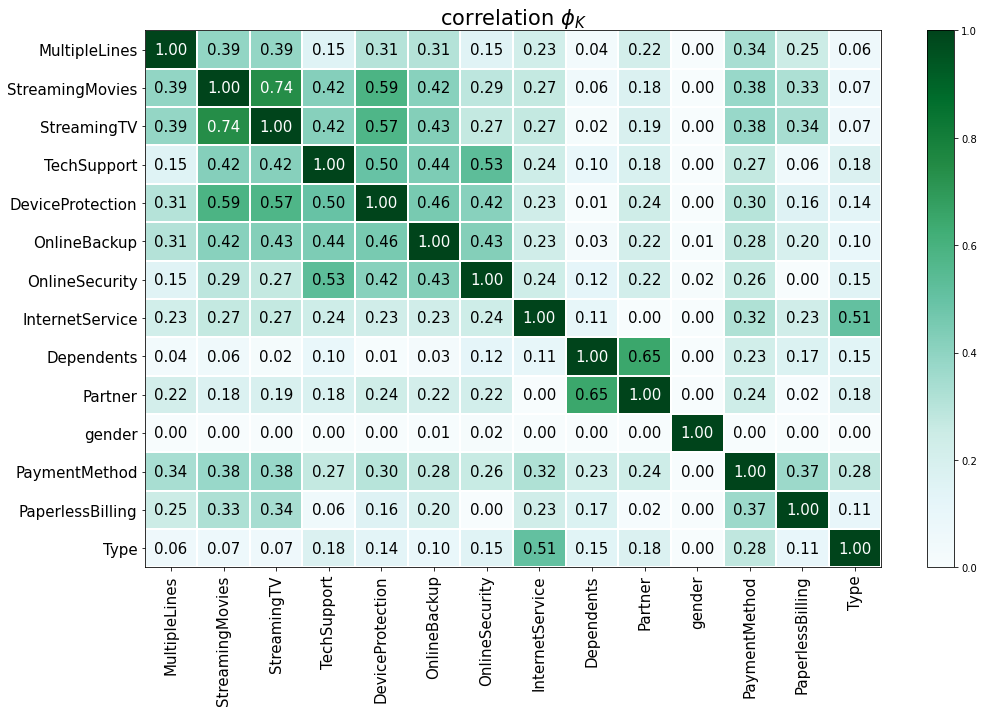

In [ ]:
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns,
                       y_labels=phik_overview.index,
                       vmin=0, vmax=1, color_map="BuGn",
                       title=r"correlation $\phi_K$",
                       fontsize_factor=1.5,
                       figsize=(15,10))
plt.tight_layout()

Самая сильная корреляция между признаками StreamingMovies и StreamingTV. Но поскольку она не превышает 0.8, оставим оба признака для дальнейшего обучения.

Для целей будущего моделирования создадим отдельный список колонок с категориальными данными.

In [ ]:
cat_columns=['Type', 'PaperlessBilling', 'PaymentMethod',
       'gender', 'Partner', 'Dependents', 'SeniorCitizen',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']

### Разделение на обучающую и тестовую выборки, масштабирование и кодирование признаков

Создадим тренировочную и тестовую выборки из соотношения 60:25 для работы с `CatBoostClassifier`

In [ ]:
X = df.drop(['Churn'], axis=1)
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=SEED )
print(f'Тренировочная выборка: {X_train.shape},{y_train.shape}')
print(f'Тестовая выборка: {X_test.shape},{y_test.shape}')

Тренировочная выборка: (5268, 18),(5268,)
Тестовая выборка: (1757, 18),(1757,)


Преобразуем категориальные значения исходной таблице методом прямого кодирования (OHE). Разобьем признаки на тренировочную, валидационную и тестовые выборки из соотношения 60%:20%:20% для работы с `LightGBM`. Преобразуем масштаб полученных данных методом стандартизации.

Пробразуем категориальные признаки для `Логистической регрессии`

In [ ]:
ohe_enc=OneHotEncoder(drop='first')
ohe_enc.fit(df[cat_columns])
new_columns=ohe_enc.get_feature_names(cat_columns)
X_train_ohe=pd.DataFrame(ohe_enc.transform(df[cat_columns]).toarray(),columns=new_columns)
data_ohe=X_train_ohe.join(df_numeric)

Подготовим признаки для `Логистической регрессии`.

In [ ]:
target=data_ohe['Churn']
features = data_ohe.drop(['Churn','TotalCharges'] , axis=1) #дополнительно удаляем признак MonthlyCharges для избавления от мультиколлинеарности с TotalCharges
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state = SEED, stratify = target)
numeric = ['MonthlyCharges','UsagePeriod']
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])
print(features_train.shape) #проверим объем полученных данных по каждой выборке
print (features_test.shape)

(5268, 21)
(1757, 21)


## Подбор гиперпараметров и обучение моделей

### Подбор гиперпараметров и обучение `LGBM`

Пдберем гиперпараметры для `LightGBM`.

In [ ]:
param_grid = {'learning_rate': [0.1, 0.3, 0.5, 0.7],
              'max_depth': [2, 10, 15],
              'num_leaves': [4,10,30]
             }
lgbm = lgb.LGBMClassifier(random_state=SEED,class_weight='balanced')

In [ ]:
grid_lgb = RandomizedSearchCV(lgbm, 
                              param_grid, 
                              cv=5, 
                              n_jobs=-1,
                              scoring='roc_auc', 
                              verbose = False)

In [ ]:
grid_lgb.fit(features_train,target_train) #обучим модель на тренировочных данных

RandomizedSearchCV(cv=5,
                   estimator=LGBMClassifier(class_weight='balanced',
                                            random_state=171022),
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.1, 0.3, 0.5, 0.7],
                                        'max_depth': [2, 10, 15],
                                        'num_leaves': [4, 10, 30]},
                   scoring='roc_auc', verbose=False)

In [ ]:
grid_lgb.best_params_ #наилучшие параметры для LightGBM

{'num_leaves': 30, 'max_depth': 2, 'learning_rate': 0.7}

In [ ]:
grid_lgb.best_score_

0.9021716068097925

In [ ]:
res=[] #метрики внесем в отдельный список для дальнейшего сравнения моделей
res.append(grid_lgb.best_score_)
          

### Подбор гиперпараметров и обучение `CatBoostClassifier`

Подберем лучшие гиперпарамеры для `CatBoostClassifier`.

In [ ]:
parameters ={"iterations": range(40,100,10),
          "depth": range(4,10,2),
          'learning_rate': np.arange(0.01, 0.3,0.01)}

cbc = CatBoostClassifier(random_state=SEED,cat_features=cat_columns,loss_function='CrossEntropy')

grid_cbc = RandomizedSearchCV(cbc, parameters, cv=5,
                              n_jobs=-1, scoring='roc_auc',verbose=False)



In [ ]:
grid_cbc.fit(X_train,y_train) #обучим модель на тренировочных данных

0:	learn: 0.6048556	total: 58.7ms	remaining: 5.23s
1:	learn: 0.5534254	total: 76.6ms	remaining: 3.37s
2:	learn: 0.5171098	total: 87.7ms	remaining: 2.54s
3:	learn: 0.4871231	total: 96ms	remaining: 2.06s
4:	learn: 0.4652608	total: 104ms	remaining: 1.76s
5:	learn: 0.4458484	total: 112ms	remaining: 1.56s
6:	learn: 0.4328194	total: 120ms	remaining: 1.43s
7:	learn: 0.4235468	total: 128ms	remaining: 1.31s
8:	learn: 0.4147569	total: 137ms	remaining: 1.23s
9:	learn: 0.4082094	total: 145ms	remaining: 1.16s
10:	learn: 0.4026077	total: 154ms	remaining: 1.1s
11:	learn: 0.3976071	total: 162ms	remaining: 1.05s
12:	learn: 0.3919484	total: 170ms	remaining: 1.01s
13:	learn: 0.3879582	total: 178ms	remaining: 968ms
14:	learn: 0.3843275	total: 187ms	remaining: 934ms
15:	learn: 0.3814716	total: 195ms	remaining: 902ms
16:	learn: 0.3784550	total: 203ms	remaining: 870ms
17:	learn: 0.3764085	total: 213ms	remaining: 851ms
18:	learn: 0.3739113	total: 221ms	remaining: 826ms
19:	learn: 0.3718074	total: 229ms	remain

RandomizedSearchCV(cv=5,
                   estimator=<catboost.core.CatBoostClassifier object at 0x7f8e20185590>,
                   n_jobs=-1,
                   param_distributions={'depth': range(4, 10, 2),
                                        'iterations': range(40, 100, 10),
                                        'learning_rate': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29])},
                   scoring='roc_auc', verbose=False)

In [ ]:
grid_cbc.best_params_ #лучшие параметры для CatBoostClassifier

{'learning_rate': 0.26, 'iterations': 90, 'depth': 8}

In [ ]:
grid_cbc.best_score_

0.8717811365462287

In [ ]:
res.append(grid_cbc.best_score_)

### Подбор гиперпараметров и обучение `Логистической регрессии`

Подберем лучшие параметры для `Логистической регрессии`.

In [ ]:
parameters ={'C':np.arange(0.01, 0.3,0.01), 'penalty': ['l1', 'l2', 'elasticnet', 'none']}
lr = LogisticRegression(random_state = SEED, solver ='lbfgs',max_iter=100,class_weight='balanced')
grid_lr = RandomizedSearchCV(lr, parameters, cv=5,n_jobs=-1, scoring='roc_auc')


In [ ]:
grid_lr.fit(features_train,target_train) #обучим модель на тренировочных данных

RandomizedSearchCV(cv=5,
                   estimator=LogisticRegression(class_weight='balanced',
                                                random_state=171022),
                   n_jobs=-1,
                   param_distributions={'C': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29]),
                                        'penalty': ['l1', 'l2', 'elasticnet',
                                                    'none']},
                   scoring='roc_auc')

In [ ]:
grid_lr.best_params_ #наилучшие параметры для LR

{'penalty': 'none', 'C': 0.05}

In [ ]:
grid_lr.best_score_

0.8443276489672

In [ ]:
res.append(grid_lr.best_score_)
          

## Анализ моделей

### Сравнительная таблица метрик `ROC-AUC` и `Accuracy` для всех моделей

In [ ]:
pd.DataFrame(res,index =['LGBM','CBC','LR'], columns=['ROC-AUC'])

,ROC-AUC
LGBM,0.902172
CBC,0.871781
LR,0.844328


Наилучший показатель `ROC-AUC` дала модель `LightGBM`, проверим её на тестовой выборке.

###  Тестирование лучшей модели на тестовой выборке

In [ ]:
best_model=grid_lgb.best_estimator_
best_model.fit(features_train,target_train)
prediction=best_model.predict(features_test)
probabilities_test = best_model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
print(f'Accuracy лучшей модели на тестовой выборке: {round(accuracy_score(target_test,prediction),2)}; ROC-AUC лучшей модели на тестовой выборке: {round(roc_auc_score(target_test,probabilities_one_test),2)}')
                

Accuracy лучшей модели на тестовой выборке: 0.82; ROC-AUC лучшей модели на тестовой выборке: 0.9


Метрики модели на тестовой выборке подходят для решения поставленной задачи. 

Будем рекомендовать модель `LightGBM` с выбранными параметрами в качестве решения.

###  Построение ROC кривой для лучшей модели

На тестовой выборке мы достигли достаточного показателя метрики Accuracy и ROC_AUC. 

Чтобы выявить, как сильно наша модель отличается от случайной, посчитаем площадь под ROC-кривой — ROC-AUC 

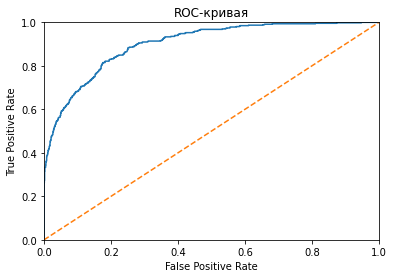

0.9017019541263026


In [ ]:
probabilities_test = grid_lgb.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

auc_roc = roc_auc_score(target_test, probabilities_one_test)
print(auc_roc)

Значение ROC-AUC хотя и далеко еще от единицы, но уже значительно выше аналогичного показателя для случайной модели (0.5). 
Что позволяет утверждать, что с использованием найденной модели мы с большой долей вероятности сможем спрогнозировать останется ли клиент в телекоме, исходя из заданных параметров, или уйдет из него.

### Проведение анализа `features importances` для лучшей модели

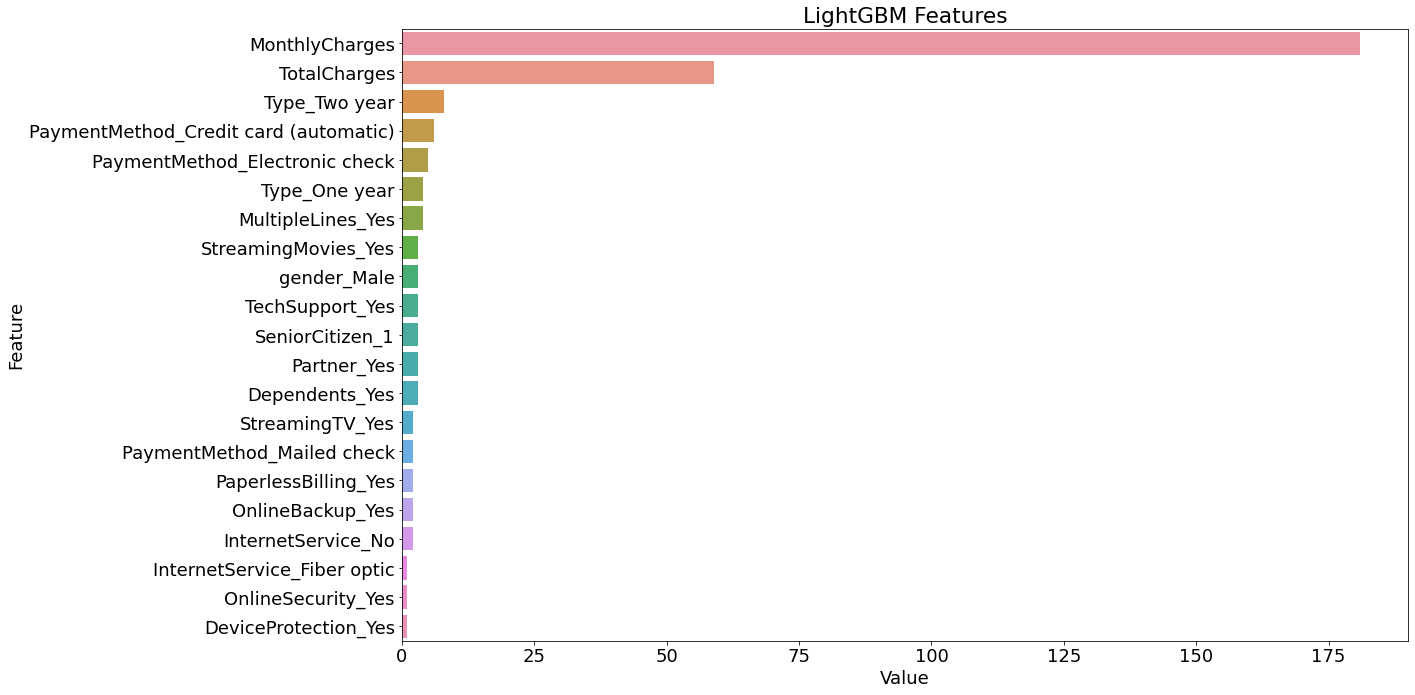

In [ ]:
feature_imp = pd.DataFrame(sorted(zip(best_model.feature_importances_,data_ohe.columns)), columns=['Value','Feature'])
plt.figure(figsize=(20, 10))
plt.rcParams['font.size'] = 18
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()

Как видно из приведенной таблицы, наиболее значимым признаком для работы модели является `MonthlyCharges`.

## Выводы

В ходе работы над проектом были проанализированы 4 датасета с данными, преобразованы типы данных и заполнены пропуски. При подготовке к моделированию были удалены нерелевантные признаки, добавлен новый признак, отражающий длительность пользования тарифом, произведена обработка категориальных данных.

Были подобраны гиперпараметры и проведено обучение трех моделей. По резульататм сравнения метрики ROC-AUC модель LightGBM выбрана в качестве лучшей модели. Значение ROC-AUC на тестовых данных составило 0.91 

Наибольшее внимание при рассмотрении признаков следует уделять ежемесячным платежам, они являются определяющим фактором для решения клиентов о дальнейшем пользовании тарифом.

Использование данной модели с параметрами  {'num_leaves': 4, 'max_depth': 10, 'learning_rate': 0.7} позволит делать максимально достоверные предсказания по оттоку клиентов из Телекома.

# Отчет по решению

Были выполнены все обзначенные пункты плана, некоторые из них пришлось объединить или поменять местами.
Например, преобразование типов данных и заполнение пропусков были частично проведены в разделе исследовательского анализа данных, такая последовательность логичнее в том числе для построения графиков исследования данных.
Для обучения моделей был использован CatBoostClassifier вместо RandomForestClassifier, т.к. обе модели основаны на деревьях решений, но CatBoost, на мой взгляд, более совершенная модель и в итоге показала результаты близкие к резульататам лучшей модели. Думаю, если дополнительно поработать с данными и с параметрами модели, качество CatBoost можно было бы значително улучшить.

При выполнении проекта были трудности:
* с обработкой данных формата datetime, я неверно перевел дни в целочисленные данные и в итоге получил некорректные данные в новом признаке UsagePeriod;
* разделял данные дополнительно на валидационную выборку, хотя в RandomizedGridSearchCV уже проводится проверка параметров модели на косс-валидации и потребности в отдельной валидационной выборке нет, вплоследствии оставил только тренировочную и тестовую выборки;
* первоначально не учитывал дисбаланс данных в целевом признаке и получал очень низкую метрику качества логистической регрессии, она оказалась наиболее чувствительна к дисбалансу.

Ключевыми шагами в решении задачи были:
* определение целевого признака;
* добавление и удаление признаков;
* выбор моделей и метрик качества;
* выбор параметров для моделей с учетом дисбаланса целевого признака и наличия категориальных признаков

<div class="alert alert-info"> <b> 
Для обучения модели использовались следующие признаки:
    
 * 'Type',  
 * 'PaperlessBilling',
 * 'PaymentMethod',
 * 'gender', 
 * 'Partner', 
 * 'Dependents', 
 * 'SeniorCitizen',
 * 'InternetService', 
 * 'OnlineSecurity', 
 * 'OnlineBackup', 
 * 'DeviceProtection',
 * 'TechSupport', 
 * 'StreamingTV', 
 * 'StreamingMovies',
 * 'MultipleLines', 
 * 'MonthlyCharges', 
 * 'UsagePeriod'    
</div>
    
В качестве итоговой модели была определена Light GBM с параметрами {'num_leaves': 4, 'max_depth': 10, 'learning_rate': 0.7} 
Она показала roc_auc на тестовой выборке 0.91
